In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from tqdm.auto import tqdm
from rl_analysis.plotting import setup_plotting_env, savefig
from rl_analysis.util import rle
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [21]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
common_cfg = analysis_config["common"]
figure_cfg = analysis_config["figures"]

In [22]:
setup_plotting_env()

In [24]:
df = pd.read_parquet(os.path.join(raw_dirs["misc"],"latencies_stim.parquet"))

/tmp/ipykernel_1567795/3597099937.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


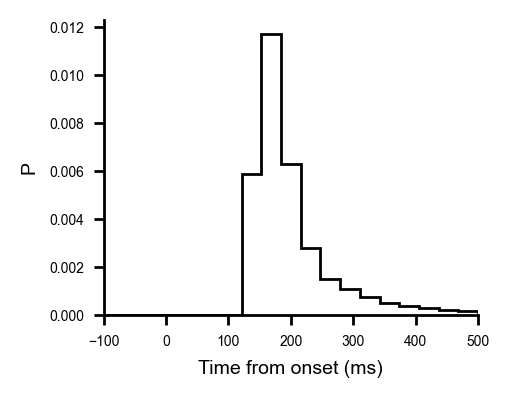

In [25]:
fig, ax = plt.subplots(1, figsize=(2.5, 2))
sns.distplot(
    df.loc[df["latency_type"] == "onset", "latency"] * 1e3 / 30,
    np.linspace(-100, 500, 20),
    ax=ax,
    kde=False,
    color="deepskyblue",
    norm_hist=True,
    hist_kws={"edgecolor": "k", "linewidth": 1, "histtype": "step", "alpha": 1},
)
ax.set_ylabel("P")
ax.set_xlabel("Time from onset (ms)")
plt.tight_layout()
plt.xlim(-100, 500)
# plt.yticks(np.round(np.array(plt.ylim()) * 1e2) / 1e2)
sns.despine()
savefig(basename=os.path.join(figure_cfg["store_dir"], "stim_latencies_onset"), bbox_inches="tight")


In [28]:
rawdat = np.fromfile(
    os.path.join(raw_dirs["misc"], "latencies_stim_arduino_test.dat"),
    "<f8",
)
new_dat = np.zeros((3, len(rawdat) // 3), dtype="float32")

for i in range(new_dat.shape[0]):
    new_dat[i] = rawdat[i::3]

In [29]:
actual_crossings = np.where(np.logical_and(new_dat[0][:-1] < 1, new_dat[0][1:] >= 1))[0]
ttl_crossings = np.where(np.logical_and(new_dat[1][:-1] < 1, new_dat[1][1:] >= 1))[0]

In [30]:
latencies = []
fs = 2e3
for i, crossings in enumerate(actual_crossings):
    diffs = ttl_crossings - crossings
    diffs = diffs[diffs > 0]
    if len(diffs) > 0:
        latencies.append(np.min(diffs) * 1e3 / 2e3)

In [31]:
setup_plotting_env()

/tmp/ipykernel_1567795/1768815882.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


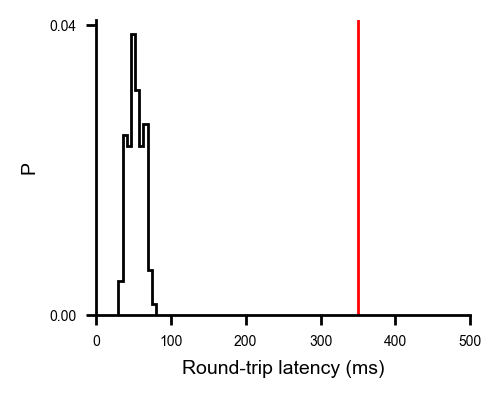

In [36]:
fig, ax = plt.subplots(1, figsize=(2.5, 2))
sns.distplot(
    latencies,
    np.linspace(30, 80, 10),
    ax=ax,
    kde=False,
    color="deepskyblue",
    norm_hist=True,
    hist_kws={"edgecolor": "k", "linewidth": 1, "histtype": "step", "alpha": 1},
)
ax.set_ylabel("P")
ax.set_xlabel("Round-trip latency (ms)")
plt.tight_layout()
plt.xlim(0, 500)
plt.yticks(np.round(np.array(plt.ylim()) * 1e2) / 1e2)
plt.axvline(x=350, color="r")  # hardcoded from value reported in MS (400 ms +/-, rounded down to 350, conservative estimate)
sns.despine()
savefig(basename=os.path.join(figure_cfg["store_dir"], "stim_latencies_roundtrip"), bbox_inches="tight")
plt.show()